<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Deep-Learning/TransferLearning/horses_or_humans_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
[Inspiration](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

We can use pre-trained Convolution NeuralNetworks on larger dataset instead of building our own Convolution NeuralNetwork from scratch.
We have different pre-trained CNNs on ImageNet dataset that spans across 1000 categories. 

## Import required libraries

In [0]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

## Load dataset

In [71]:
os.chdir('.')
print(os.curdir)
! pwd

.
/content


In [0]:
download_dataset = False
if download_dataset:
    # ! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
    # ! wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
    
    ! mkdir Data
    %cd Data
    ! mkdir horses-or-humans-dataset
    %cd horses-or-humans-dataset
    ! mkdir horse-or-human
    %cd horse-or-human
    ! mkdir train
    ! mkdir validation
    %cd /content
    ! unzip horse-or-human.zip -d /content/Data/horses-or-humans-dataset/horse-or-human/train
    ! unzip validation-horse-or-human.zip -d /content/Data/horses-or-humans-dataset/horse-or-human/validation

In [0]:
# print(os.getcwd())
dataset_base_path = r'./Data/horses-or-humans-dataset/horse-or-human'

dataset_train_path = dataset_base_path + '/train'
dataset_valid_path = dataset_base_path + '/validation'

train_horses_path = dataset_train_path + '/horses'
train_humans_path = dataset_train_path + '/humans'

valid_horses_path = dataset_valid_path + '/horses'
valid_humans_path = dataset_valid_path + '/humans'

batch_size = 4

In [0]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(dataset_train_path, transform=transformations)
valid_dataset = datasets.ImageFolder(dataset_valid_path, transform=transformations)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [75]:
class_names = train_dataset.classes
print(class_names)

['horses', 'humans']


## Load computing device

In [0]:
# Load device CUDA or CPU
def get_device():
    if not torch.cuda.is_available():
        return torch.device('cpu')
    
    return torch.device('cuda' if check_if_cuda_is_working() else 'cpu')

def check_if_cuda_is_working():
    cuda = torch.device('cuda')     # Default CUDA device

    x = torch.tensor([1., 2.], device=cuda)
    y = torch.tensor([1., 2.], device=cuda)

    try:
        print(x + y)
        return True
    except:
        return False

In [77]:
device = get_device()
print('Computing device: {}'.format(device))

tensor([2., 4.], device='cuda:0')
Computing device: cuda


## Visualize images

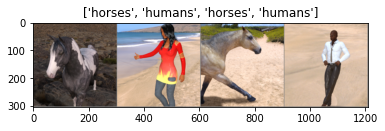

In [78]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [0]:
def is_phase_train(phase):
    return phase == 'train'
def get_loader(phase):
    return trainloader if is_phase_train(phase) else validloader
dataset_sizes = lambda phase: len(train_dataset) if is_phase_train(phase) else len(valid_dataset)

def train(model, criterion, optimizer, epochs = 10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}/{epochs}')
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            model.train() if is_phase_train(phase) else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in get_loader(phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(is_phase_train(phase)):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if is_phase_train(phase):
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes(phase)
            epoch_acc = running_corrects.double() / dataset_sizes(phase)

            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [0]:
def visualize_model(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Make a grid from batch
            out = torchvision.utils.make_grid(inputs.cpu())

            imshow(out, title=[class_names[preds[j]] for j in range(inputs.size()[0])])

            images_so_far += inputs.size()[0]
            if images_so_far >= num_images:
                break

### Train on VGGNET pre-trained model

In [81]:
model_vggnet_16 = torchvision.models.vgg16(pretrained=True)

# Set training all parameters to false
for params in model_vggnet_16.parameters():
    params.requires_grad = False

# print(model_vggnet_16)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_vggnet_16.classifier[6].in_features
features = list(model_vggnet_16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_ftrs, len(class_names))]) # Add our layer with 2 outputs
model_vggnet_16.classifier = nn.Sequential(*features) # Replace the model classifier
print(model_vggnet_16)

model_vggnet_16 = model_vggnet_16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_vggnet_16 = optim.SGD(model_vggnet_16.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [82]:
model_vggnet_16 = train(model_vggnet_16, criterion, optimizer_vggnet_16, epochs=2)

Epoch: 1/2
----------
train Loss: 0.0404 Acc: 0.9893
val Loss: 0.0437 Acc: 0.9883

Epoch: 2/2
----------
train Loss: 0.0107 Acc: 0.9971
val Loss: 0.0338 Acc: 0.9961

Training complete in 1m 1s
Best val Acc: 0.996094


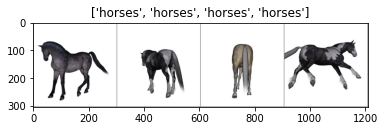

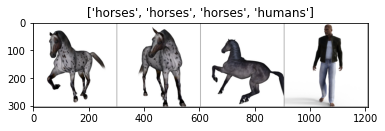

In [83]:
visualize_model(model_vggnet_16, validloader)

## Save the trained model

In [0]:
torch.save(model_vggnet_16.state_dict(), 'VGG16_On_Horse_Humans_Dataset.pt')

## Load the saved model for inferencing

In [85]:
print(type(model_vggnet_16))

<class 'torchvision.models.vgg.VGG'>


In [86]:
#model = torchvision.models.vgg.VGG()
model_vggnet_16.load_state_dict(torch.load('VGG16_On_Horse_Humans_Dataset.pt'))
model_vggnet_16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

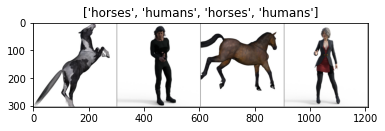

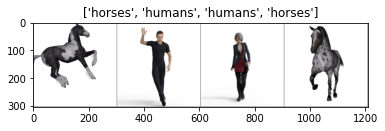

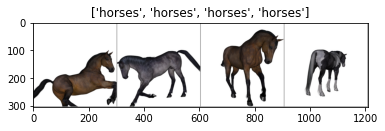

In [87]:
visualize_model(model_vggnet_16, validloader, num_images=12)

## Inference on real-world images for horses and humans

In [88]:
load_real_dataset = True
if load_real_dataset:
    os.chdir('.')
    ! unzip real-world-dataset.zip -d /content/Data

Archive:  real-world-dataset.zip
replace /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-1.jpg  
replace /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-2.jpg  
replace /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-3.jpg  
  inflating: /content/Data/real-world-dataset/horses-or-humans-dataset/horses/download-4.jpg  
  inflating: /content/Data/real-world-data

In [0]:
real_dataset_base_path = r'./Data/real-world-dataset'

real_horses_or_humans_path = real_dataset_base_path + '/horses-or-humans-dataset'

batch_size = 2

In [0]:
transformations = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

real_horses_or_humans_dataset = datasets.ImageFolder(real_horses_or_humans_path, transform=transformations)

real_horses_or_humans_loader = torch.utils.data.DataLoader(real_horses_or_humans_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

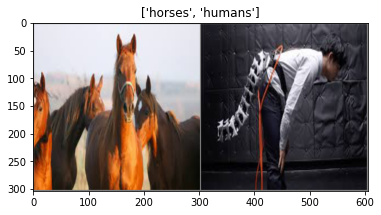

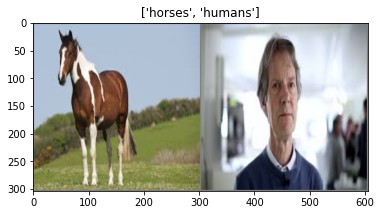

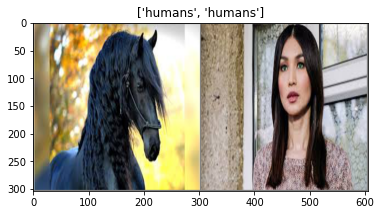

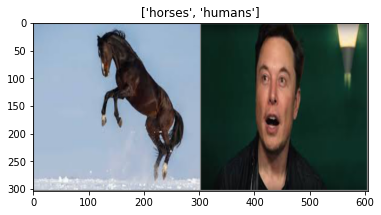

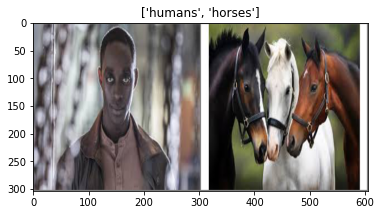

In [91]:
visualize_model(model_vggnet_16, real_horses_or_humans_loader, num_images=10)